# TP2
## Grupo 15

Carlos Eduardo Da Silva Machado A96936

Gonçalo Manuel Maia de Sousa A97485

## Problema 2

### Descrição do Problema


2. O Conway’s Game of Life é um exemplo bastante conhecido de um autómato celular . Neste problema vamos modificar as regras do autómato da seguinte forma
    1. O espaço de estados é finito definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N^2\;$ células são aqui referidas como “normais”. 
    2. No estado inicial todas as células normais estão mortas excepto  um quadrado $\,3\times 3\,$, designado por “centro”, aleatoriamente posicionado formado apenas por células vivas.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,\rho\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

### Abordagem do Problema

Para resolver este problema construimos uma máquina de estados finita que representa esse automato, de modo que cada estado é representado unicamente por uma configuração específica de células vivas e mortas.

São parametros deste problema:
1. $\rho$ a probabilidade de cada uma das células da borda estar viva.
2. $N$ o tamaho do quadro.
3. $k$ o limite imposto ao número de transições do autómato.
4. $centro$ a posição do centro aleatóriamente posicionado.

Para além do autómato é necessário verificar de as seguintes propriedades de aplicam:
1. Todos os estados acessíveis contém pelo menos uma célula viva.
2. Toda a célula normal está viva pelo menos uma vez em algum estado acessível.

## Código Python

Esta secção de codigo serve para importar as bibliotecas nesseçárias para a realização do trabalho. Além disso, é aqui que declaramos os parâmetros $N$, $\rho$ e a posição do centro 

In [1]:
import matplotlib.pyplot as plt
from pysmt.shortcuts import *
from pysmt.typing import INT
import random as rn
from pprint import pprint


Aqui são apresentadas funções auxiliares.

In [2]:
def gera_rand(p,size):
    return rn.choices([0,1],[1-p,p],k=size)

def PontosProximos(pos,N):
    x,y = pos
    p = [(x+1,y),(x-1,y),(x,y+1),(x,y-1),(x-1,y-1),(x+1,y+1),(x-1,y+1),(x+1, y-1)]
    return list(filter(lambda x: x[0] < N+1 and x[1] < N+1,  p))

# Construção da máquina de estados finita

Função de declaração.

In [3]:
def declare(c,N):
    state = dict()
    for i in range(1,N+1):
        for j in range(1,N+1):
            state[f'({i},{j})'] = Symbol(f'({i},{j})'+str(c),INT)
    return state

Função init.

In [4]:
def init(state,N,p,centro,border):
    l = list()
    for i,x in enumerate(border[0],start=1):
        l.append(Equals(state[f'({i},1)'], Int(x)))
    for j,x in enumerate(border[1],start=2):
        l.append(Equals(state[f'(1,{j})'], Int(x)))
        
    ic,jc = centro
    
    for i in range(2,N+1):
        for j in range(2,N+1):
            if i in [ic-1,ic, ic+1] and j in [jc-1, jc, jc+1]:
                l.append(Equals(state[f'({i},{j})'], Int(1)))
            else:
                l.append(Equals(state[f'({i},{j})'], Int(0)))
            
    #l.append(Equals(state['pc'], Int(0)))
    return And(l)

Função de transição.

 $$\mathsf{trans}(x_{i,j},x'_{i,j} : i,j \in N, )\;\equiv\;$$
 $$
 \left\{\begin{array}{lr}
 \forall_{i \in \{1...N\}} \quad (x'_{i,1} = x_{i,1}) & \land \\ 
 \forall_{j \in \{1...N\}} \quad (x'_{1,j} = x_{1,j}) & \end{array}\right.\\
 \land\\
 \left\{\begin{array}{lr}
 \forall_{i \in \{2...N\}} \cdot \forall{j \in \{2...N\}} \quad (x_{i,j} = 0) \land (neighbors(x_{i,j}) = 3) \land (x'_{i,j} = 1) & \lor \\
 \forall_{i \in \{2...N\}} \cdot \forall{j \in \{2...N\}} \quad (x_{i,j} = 1) \land ((neighbors(x_{i,j}) = 2) \lor neighbors(x_{i,j} = 3)) \land (x'_{i,j} = 1) & \lor\\ 
 \forall_{i \in \{2...N\}} \cdot \forall{j \in \{2...N\}} \quad (x_{i,j} = 1) \land ((neighbors(x_{i,j}) \lt 2) \lor neighbors(x_{i,j} \gt 3)) \land (x'_{i,j} = 0) & \lor\\ 
 \forall_{i \in \{2...N\}} \cdot \forall{j \in \{2...N\}} \quad (x_{i,j} = 0) \land ((neighbors(x_{i,j}) \le 2) \lor neighbors(x_{i,j} \gt 3)) \land (x'_{i,j} = 0) & \end{array}\right.
 $$

In [5]:
def trans(curr,prox,N):
    l = []
    for i in range(1,N+1):
        l.append(Equals(prox[f'({i},1)'], curr[f'({i},1)']))
    for j in range(2,N+1):
        l.append(Equals(prox[f'(1,{j})'], curr[f'(1,{i})']))
    for i in range(2,N+1):
        for j in range(2,N+1):
            valor = Plus([curr[f'({x},{y})'] for x,y in PontosProximos((i,j),N)])
            tBorn = And(Equals(curr[f'({i},{j})'], Int(0)), Equals(valor, Int(3)), Equals(prox[f'({i},{j})'], Int(1)))
            tStayAlive = And(Equals(curr[f'({i},{j})'], Int(1)), Or(Equals(valor, Int(2)),Equals(valor, Int(3))), Equals(prox[f'({i},{j})'], Int(1)))
            tDie = And(Equals(curr[f'({i},{j})'], Int(1)), Or(valor < Int(2),valor > Int(3)), Equals(prox[f'({i},{j})'], Int(0)))
            tStillDead = And(Equals(curr[f'({i},{j})'], Int(0)), Or(valor <= Int(2),valor > Int(3)), Equals(prox[f'({i},{j})'],Int(0)))
            
            l.append(Or(tBorn, tStayAlive, tDie,tStillDead))
    return And(l)



Função que usa $\textit{SMT solver}$ para gerar um possível traço de execução do programa, e mostra o estado do autómato na forma de um quadrado $N \times N$ tal que as células mortas são apresentadas com cor escura e as vivas com cor clara. 

In [6]:
    
def resolve(N,p,k,centro,border):    
    with Solver(name="z3") as s:
        
        flag = True
        
        while flag:
            
            mat_list = list()
            
            trace = [declare(i,N) for i in range(k)]
            
            s.add_assertion(init(trace[0],N,p,centro,border))

            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1],N))
            
            mat_set = set()
            
            if s.solve():
                for i in range(k):
                    matrix = []
                    for x in range(1,N+1):
                        #print([s.get_value(trace[i][f'({k},{x})']) for k in range(1,N+1)])
                        matrix.append([(s.get_value(trace[i][f'({k},{x})']).constant_value()) for k in range(1,N+1)])
                    #pprint(matrix)
                    matrix_str = str(matrix)
                    if matrix_str in mat_set:
                       flag = False
                       break
                    mat_set.add(matrix_str)
                    mat_list.append(matrix)
                    #pprint(matrix)
            else:
                print('Não foi possivel resolver')
                
            k = 2*k
                  
        for i,l in enumerate(mat_list):
            plt.imshow(l)
            plt.axis('off')
            print(i)
            plt.show()




### Exemplos e testes de aplicação.

#### Exemplo 1

In [7]:
N = 15
p = 0.5
k = 50
centro = (3,3)#(rn.randint(3,N-1),rn.randint(3,N-1))
border1 = gera_rand(p,N)
border2 = gera_rand(p,N-1)
border = (border1,border2)
print(centro)
print((border1,border2))
print(border2)

(3, 3)
([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0], [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])
[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]


0


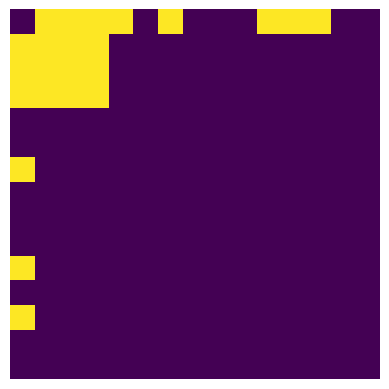

1


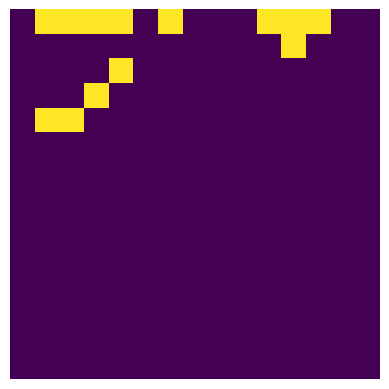

2


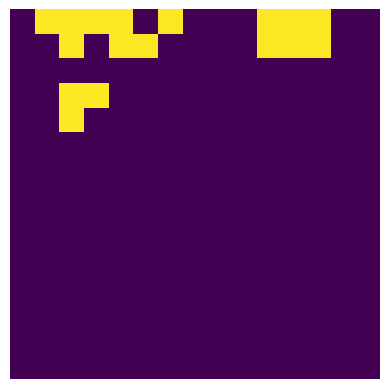

3


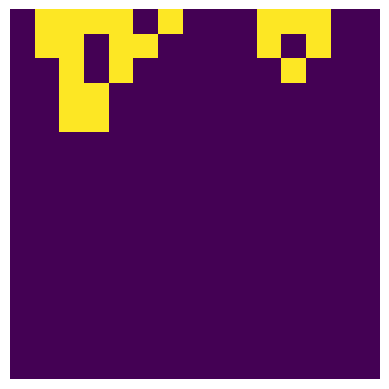

4


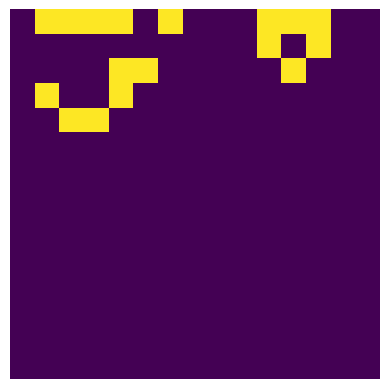

5


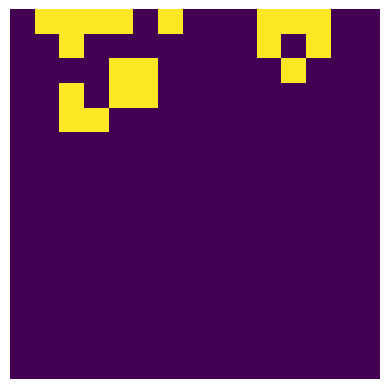

6


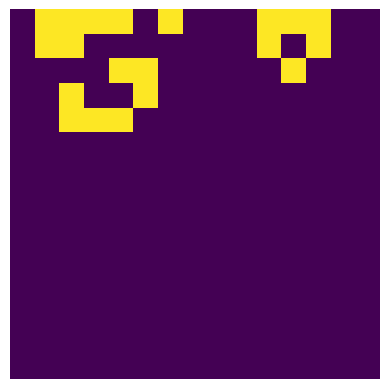

7


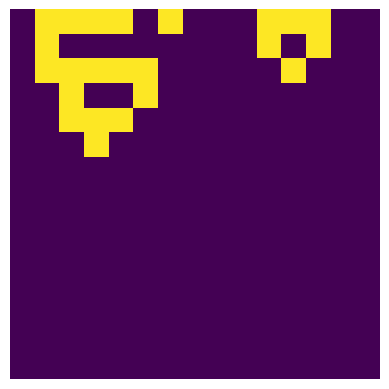

8


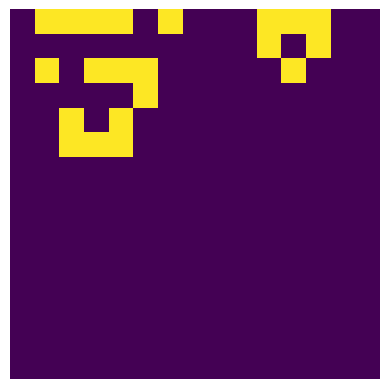

9


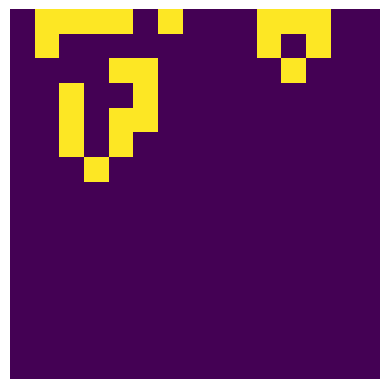

10


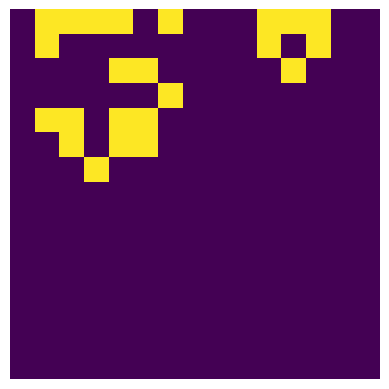

11


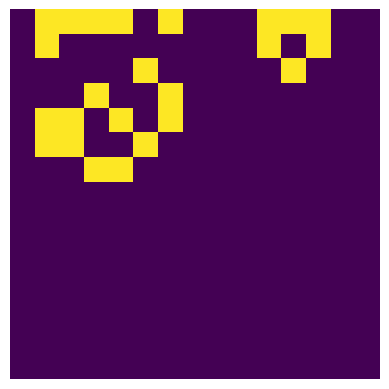

12


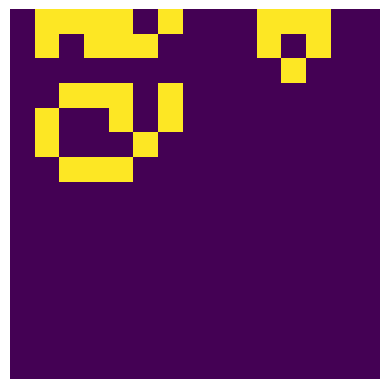

13


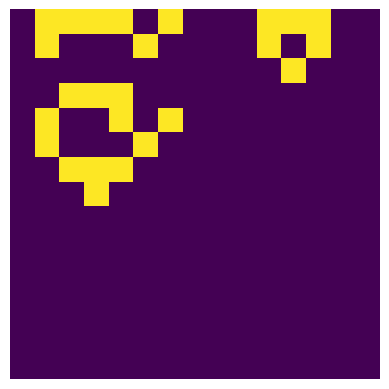

14


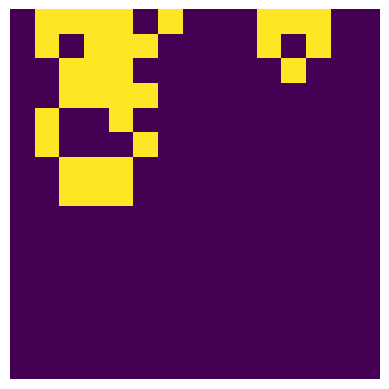

15


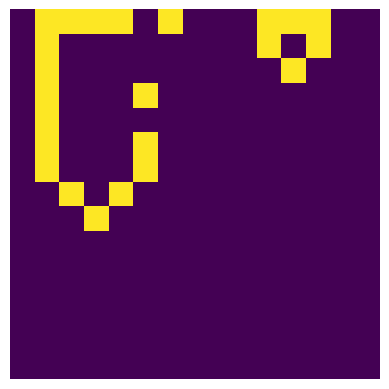

16


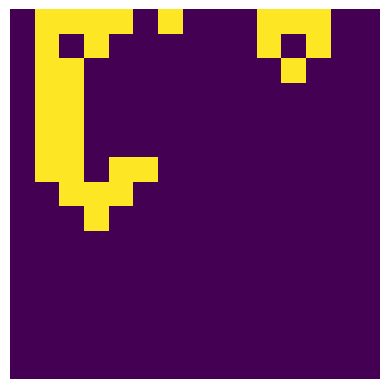

17


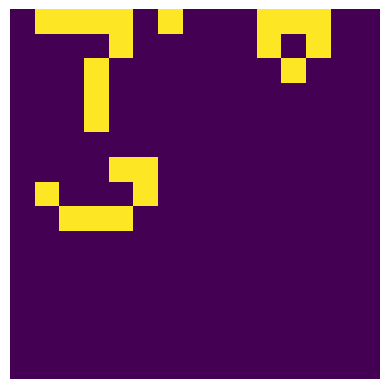

18


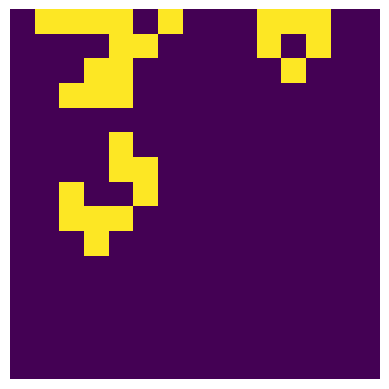

19


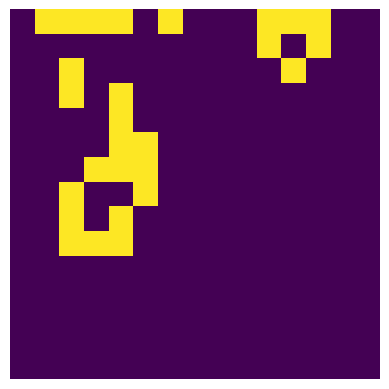

20


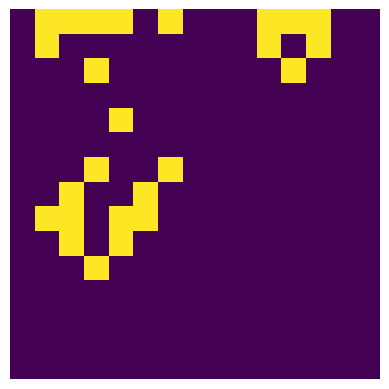

21


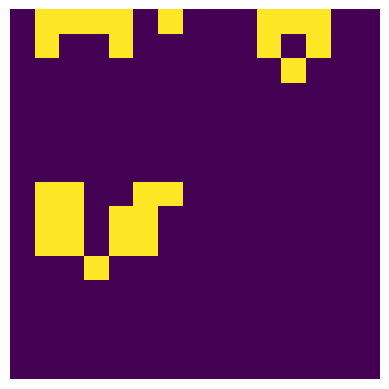

22


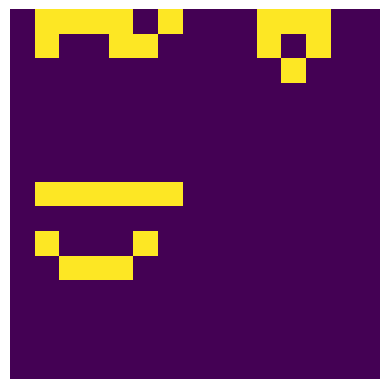

23


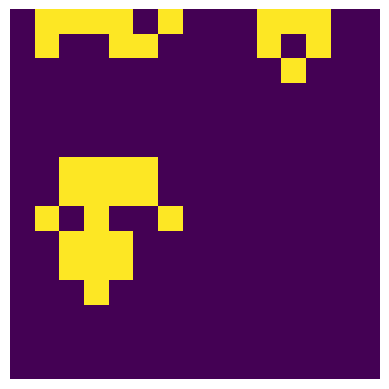

24


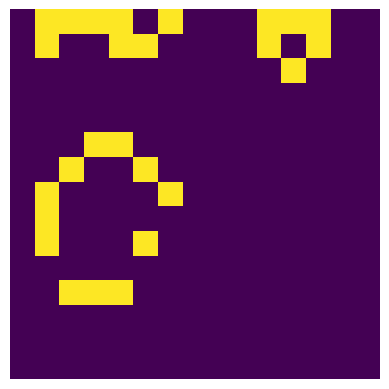

25


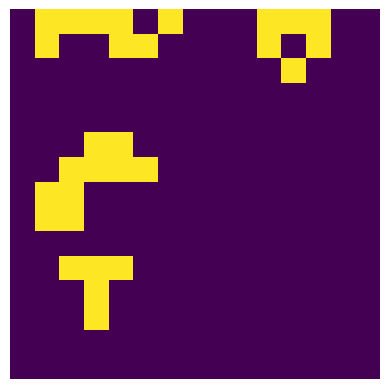

26


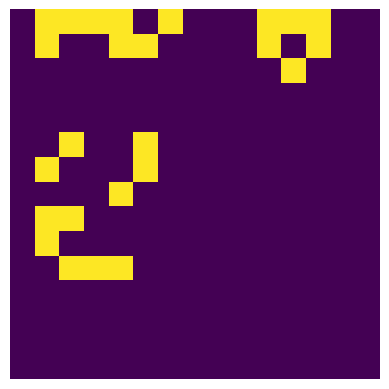

27


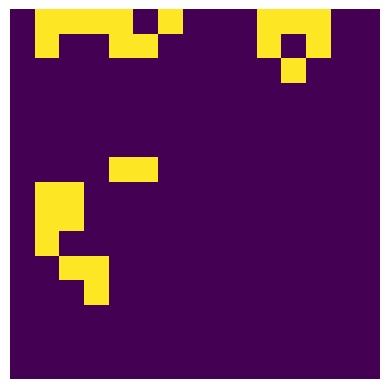

28


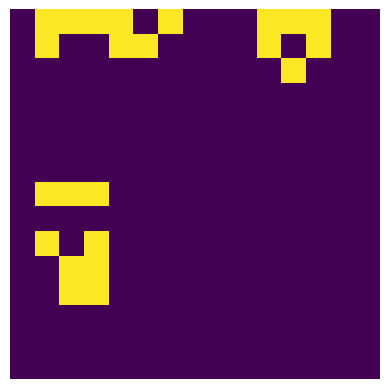

29


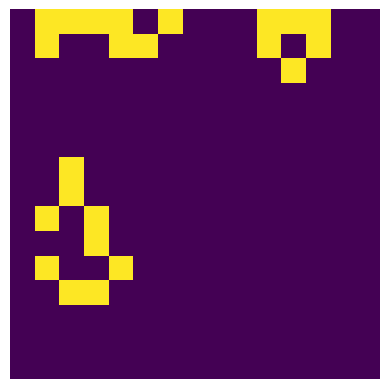

30


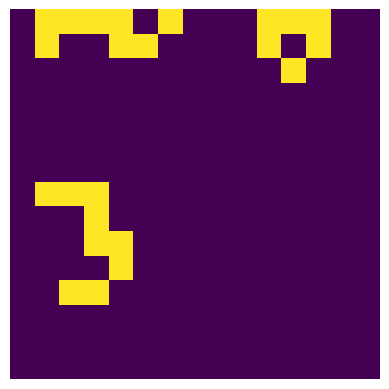

31


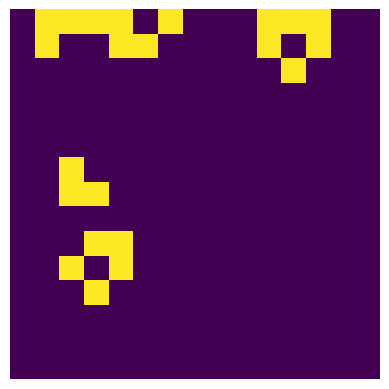

32


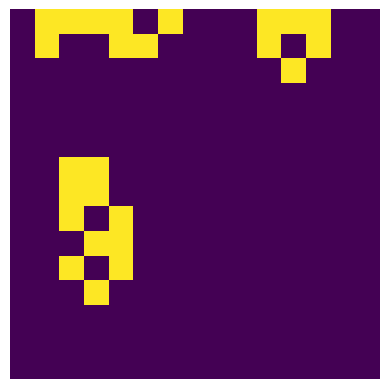

33


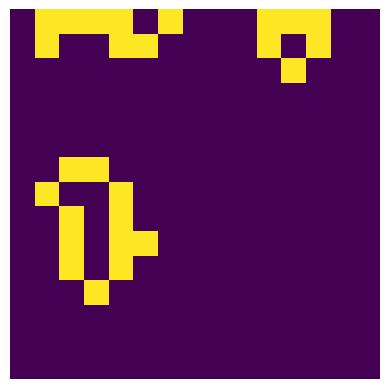

34


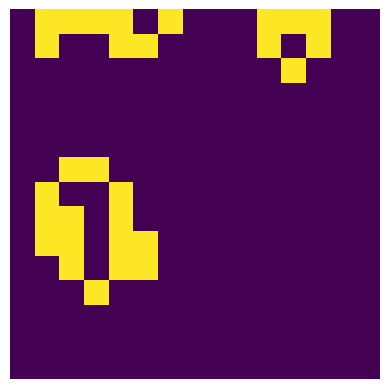

35


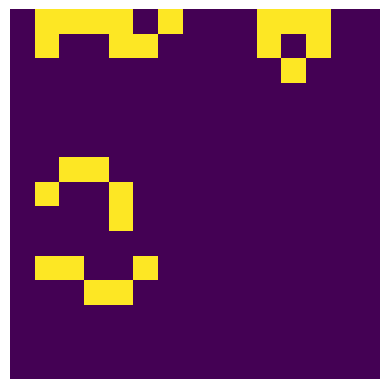

36


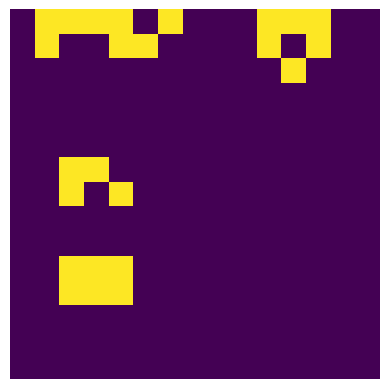

37


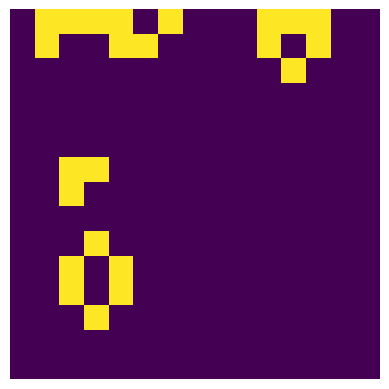

38


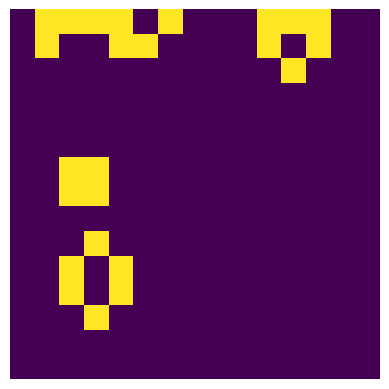

39


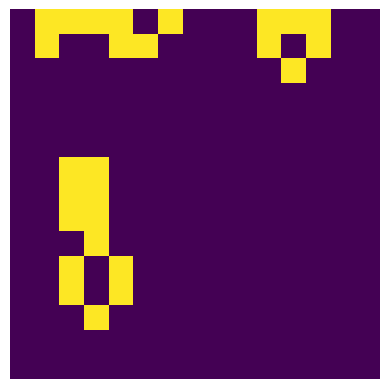

40


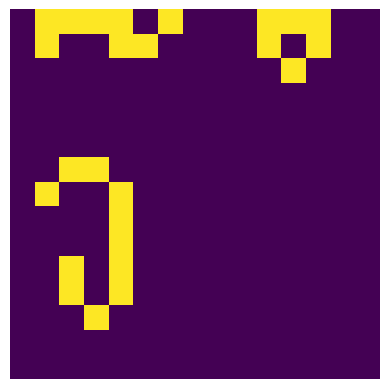

41


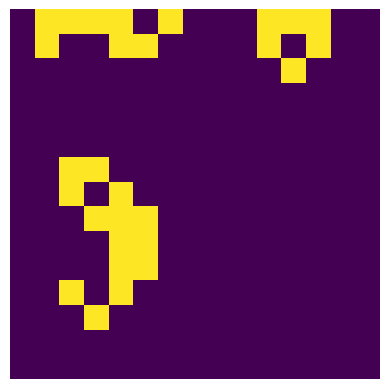

42


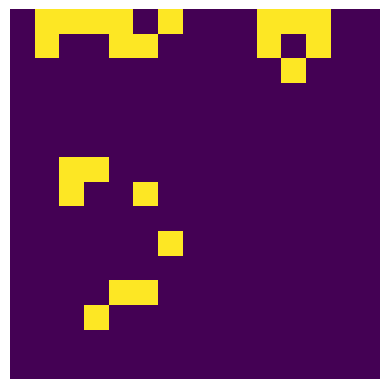

43


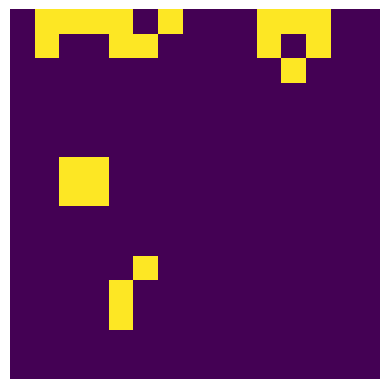

44


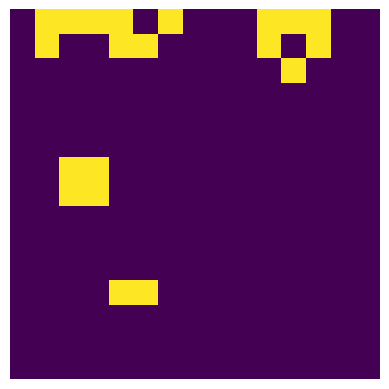

45


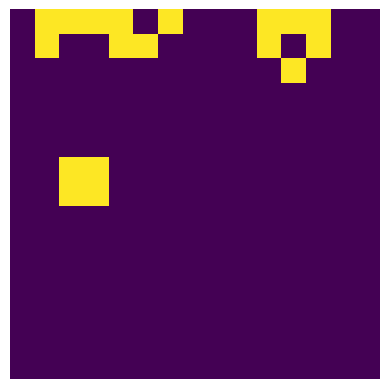

0


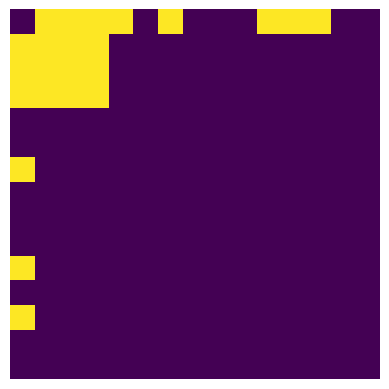

1


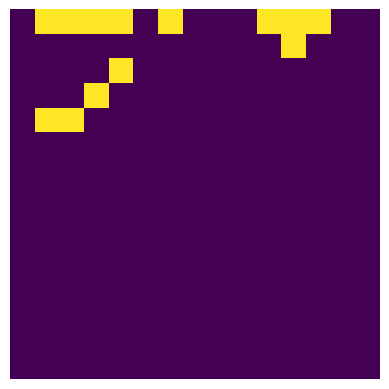

2


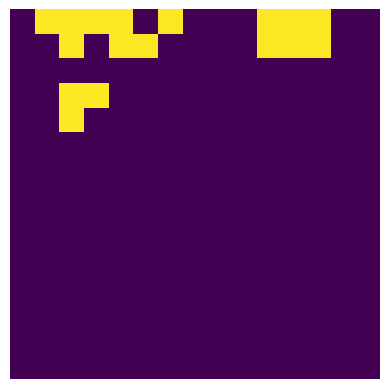

3


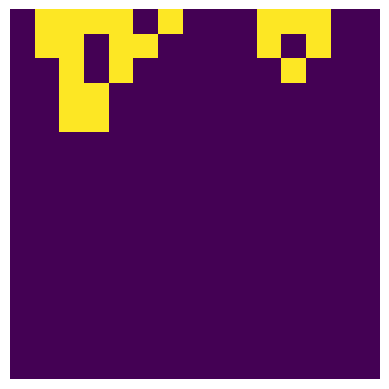

4


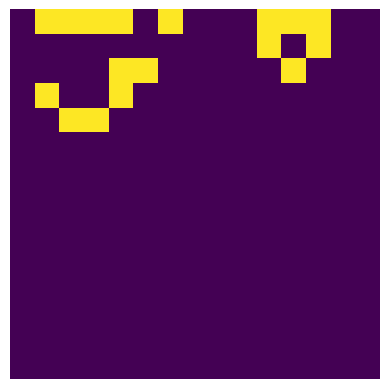

5


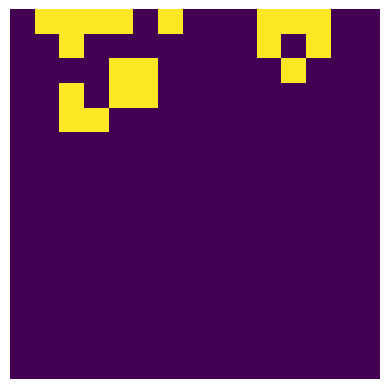

6


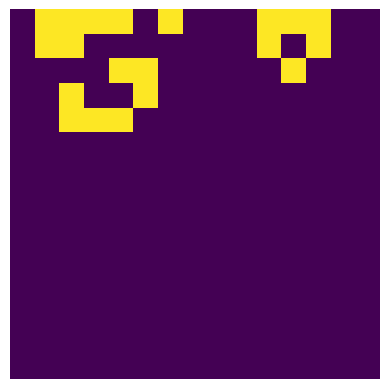

7


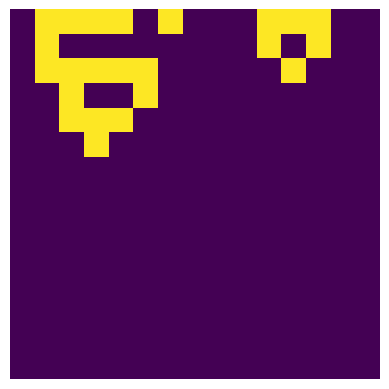

8


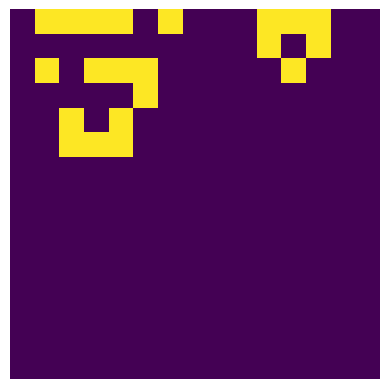

9


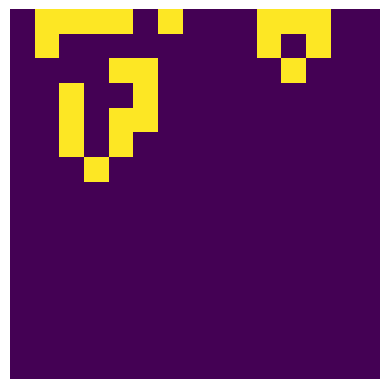

10


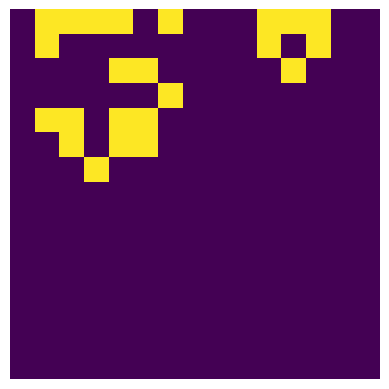

11


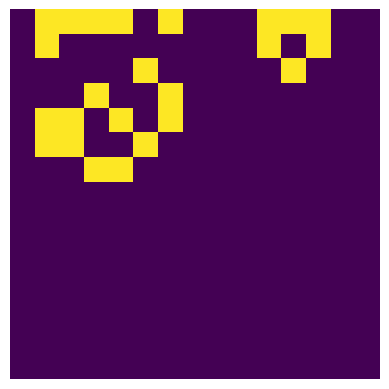

12


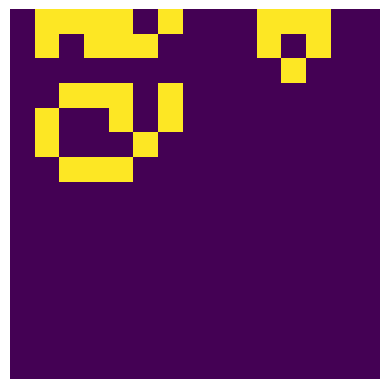

13


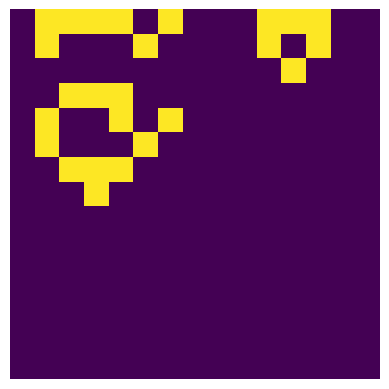

14


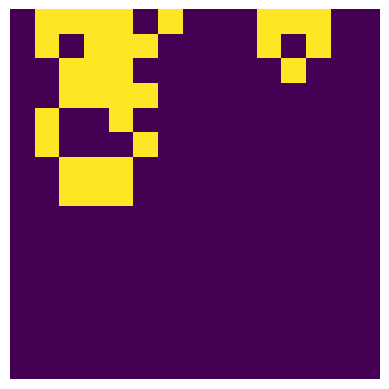

15


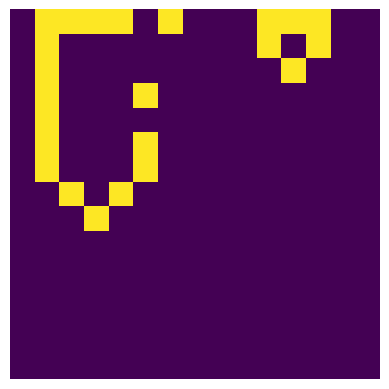

16


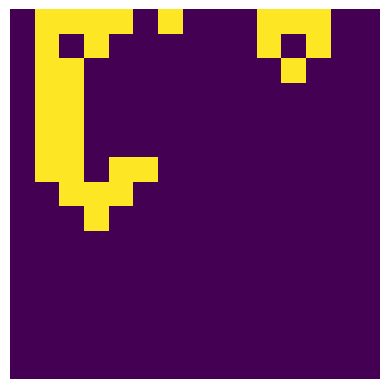

17


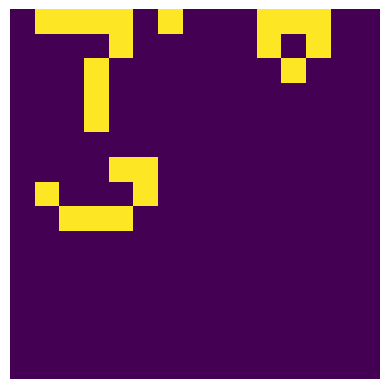

18


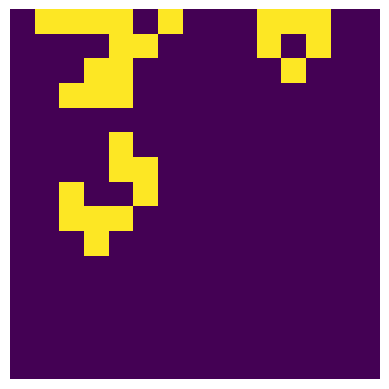

19


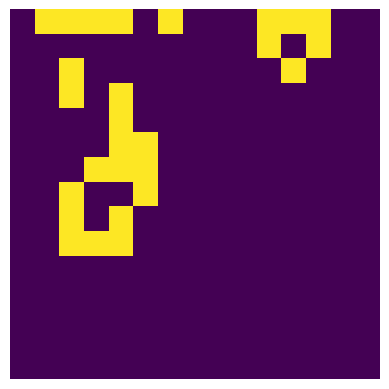

20


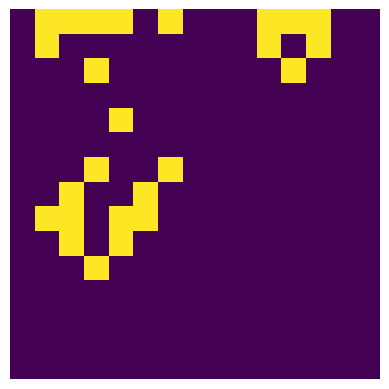

21


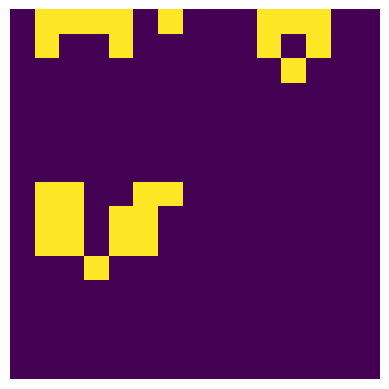

22


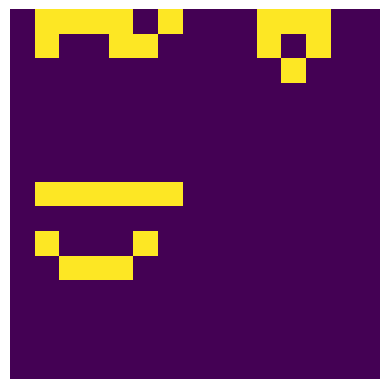

23


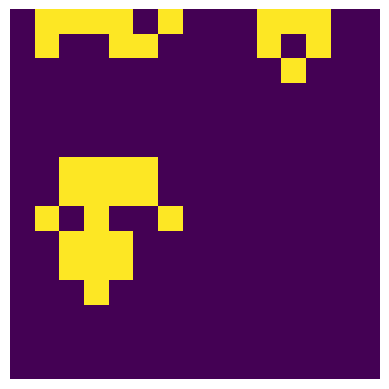

24


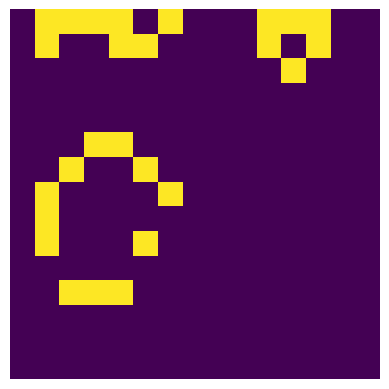

25


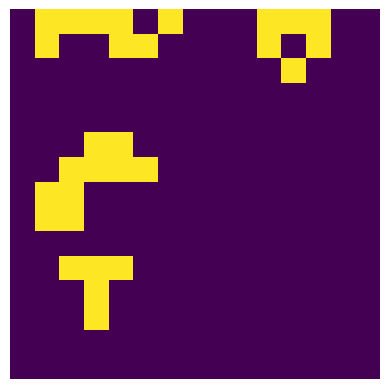

26


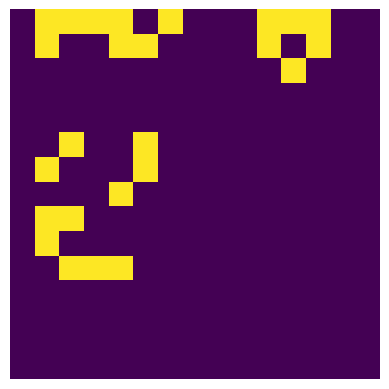

27


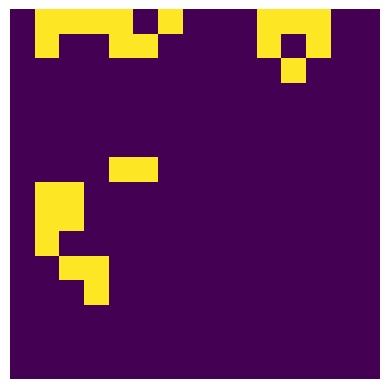

28


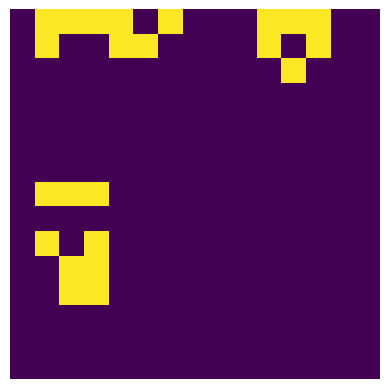

29


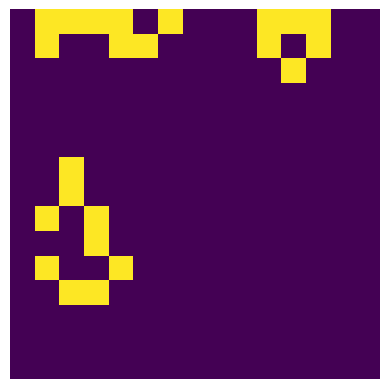

30


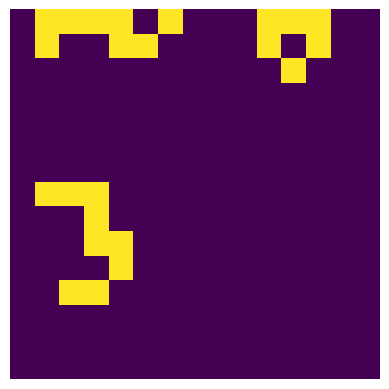

31


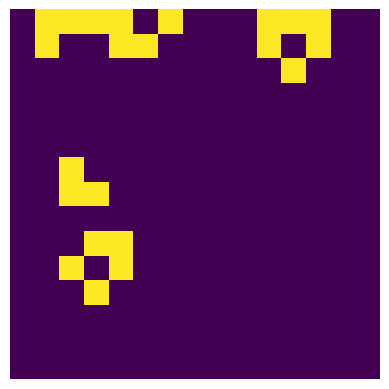

32


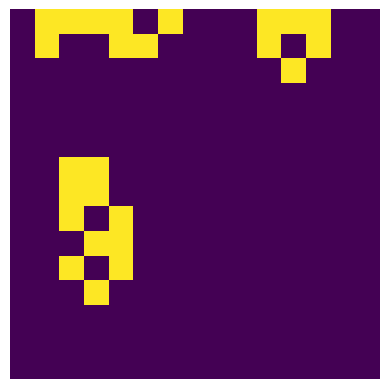

33


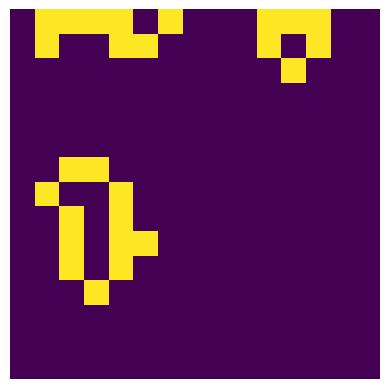

34


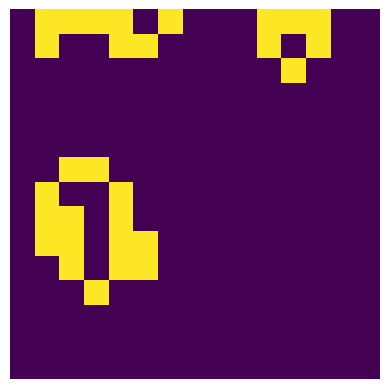

35


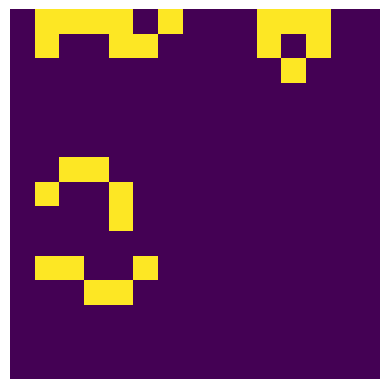

36


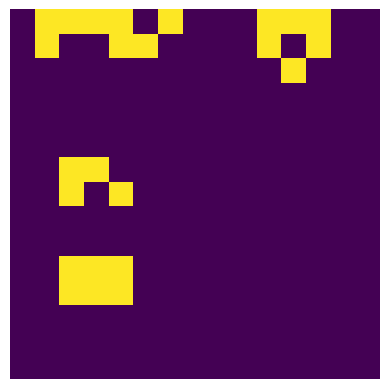

37


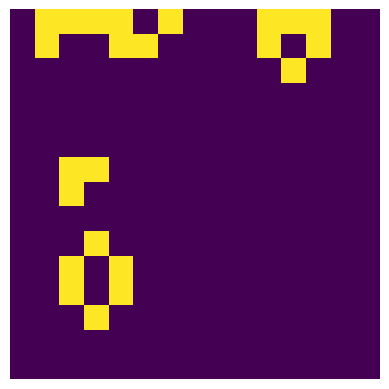

38


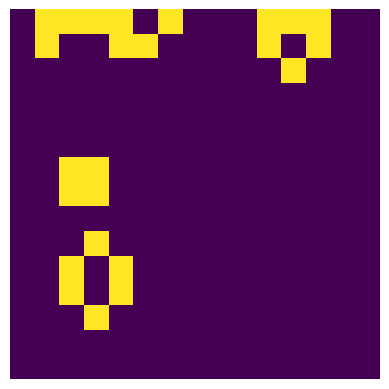

39


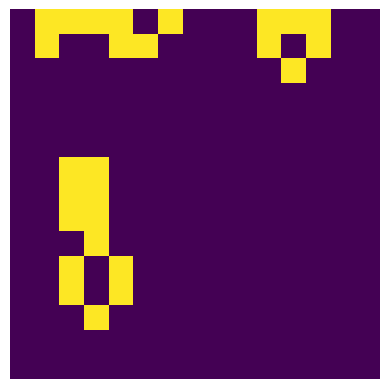

40


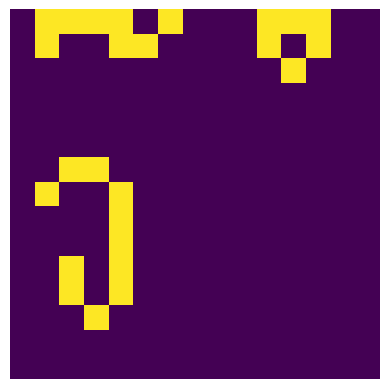

41


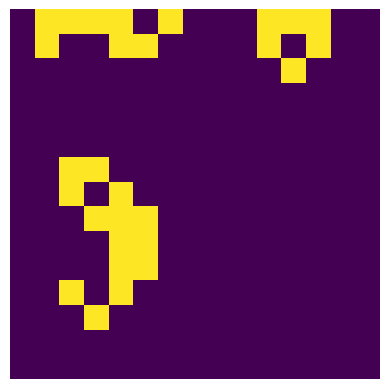

42


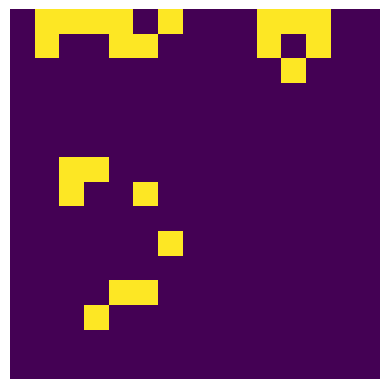

43


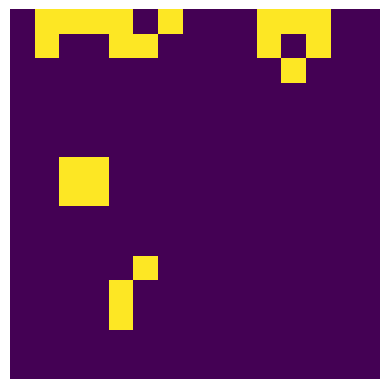

44


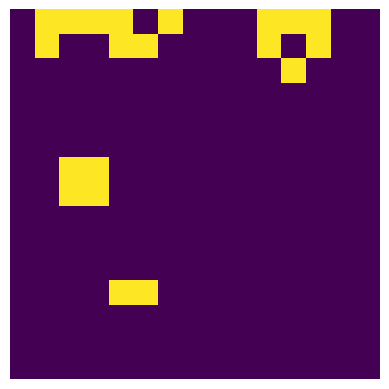

45


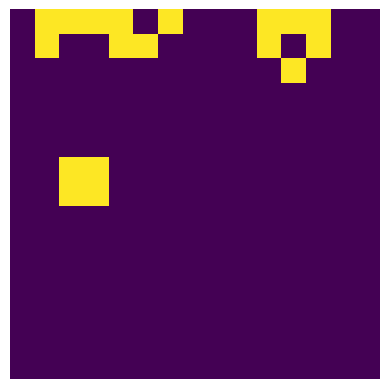

In [8]:
resolve(N,p,k,centro,border)